## Estimation of the proportion of British Columbia high-school students who regularly smoke

In [3]:
library(tidyverse)
library(haven)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

Warning message:
“package ‘tidyr’ was built under R version 4.1.2”
Warning message:
“package ‘readr’ was built under R version 4.1.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



### Introduction
...

### Preliminary Results (190 words)
Here we're reading the data set from the web

In [6]:
data <- read_sav("https://abacus.library.ubc.ca/api/access/datafile/95464?format=original&gbrecs=true")

data %>%
  head()

SCANID,MODULE,PROVID,SCHID,GRADE,SEX,SS_010,SS_020,TS_011,TV_010,⋯,DVTY2ST,DVLAST30,DVAMTSMK,DVCIGWK,DVNDSMK,DVAVCIGD,DVRES,DVURBAN,DVHHINC2,WTPP
<dbl>,<dbl+lbl>,<dbl+lbl>,<dbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,⋯,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl>,<dbl>
100224,1,35,3589267,9,1,1,13,2,3,⋯,1,1,1,8,5,2,1,2,60000,33.15
100225,1,35,3589267,9,1,1,13,1,1,⋯,1,1,10,70,7,10,1,2,60000,33.15
100226,1,35,3589267,12,1,2,NA,4,3,⋯,7,2,NA,NA,NA,NA,3,2,60000,75.14
100227,1,35,3589267,12,2,1,NA,3,2,⋯,4,1,0,0,0,0,1,2,60000,105.70
100228,1,35,3589267,12,1,1,NA,3,3,⋯,6,2,NA,NA,NA,NA,1,2,60000,75.14
100229,1,35,3589267,11,1,2,NA,4,3,⋯,7,2,NA,NA,NA,NA,1,2,60000,63.87


Next, we can filter the data set so that it contains only the observations of high-school regular smokers. What "regular smoker" means is described in the previous section, so here we filter the variables accordingly.

In [63]:
all_provinces <- data %>%
  filter(GRADE %in% 10:12,
         DVRES == 1 | DVRES == 3,
         SS_010 == 1,
         TS_011 %in% 1:2,
         TV_010 %in% 1:2,
         SS_030 == 1,
         SS_040 == 1,
         SS_060 %in% 7:8,
         WP_030 == 3 | WP_030 == 6
  ) %>%
  mutate(PROVID = as_factor(PROVID),
         GRADE = as_factor(GRADE)) %>%
  arrange(PROVID) %>%
  select(PROVID, GRADE)

all_provinces %>%
  tail()

PROVID,GRADE
<fct>,<fct>
British Columbia,Grade 12
British Columbia,Grade 10
British Columbia,Grade 12
British Columbia,Grade 12
British Columbia,Grade 11
British Columbia,Grade 10


Now we plot this data frame to explore our research question for all provinces.

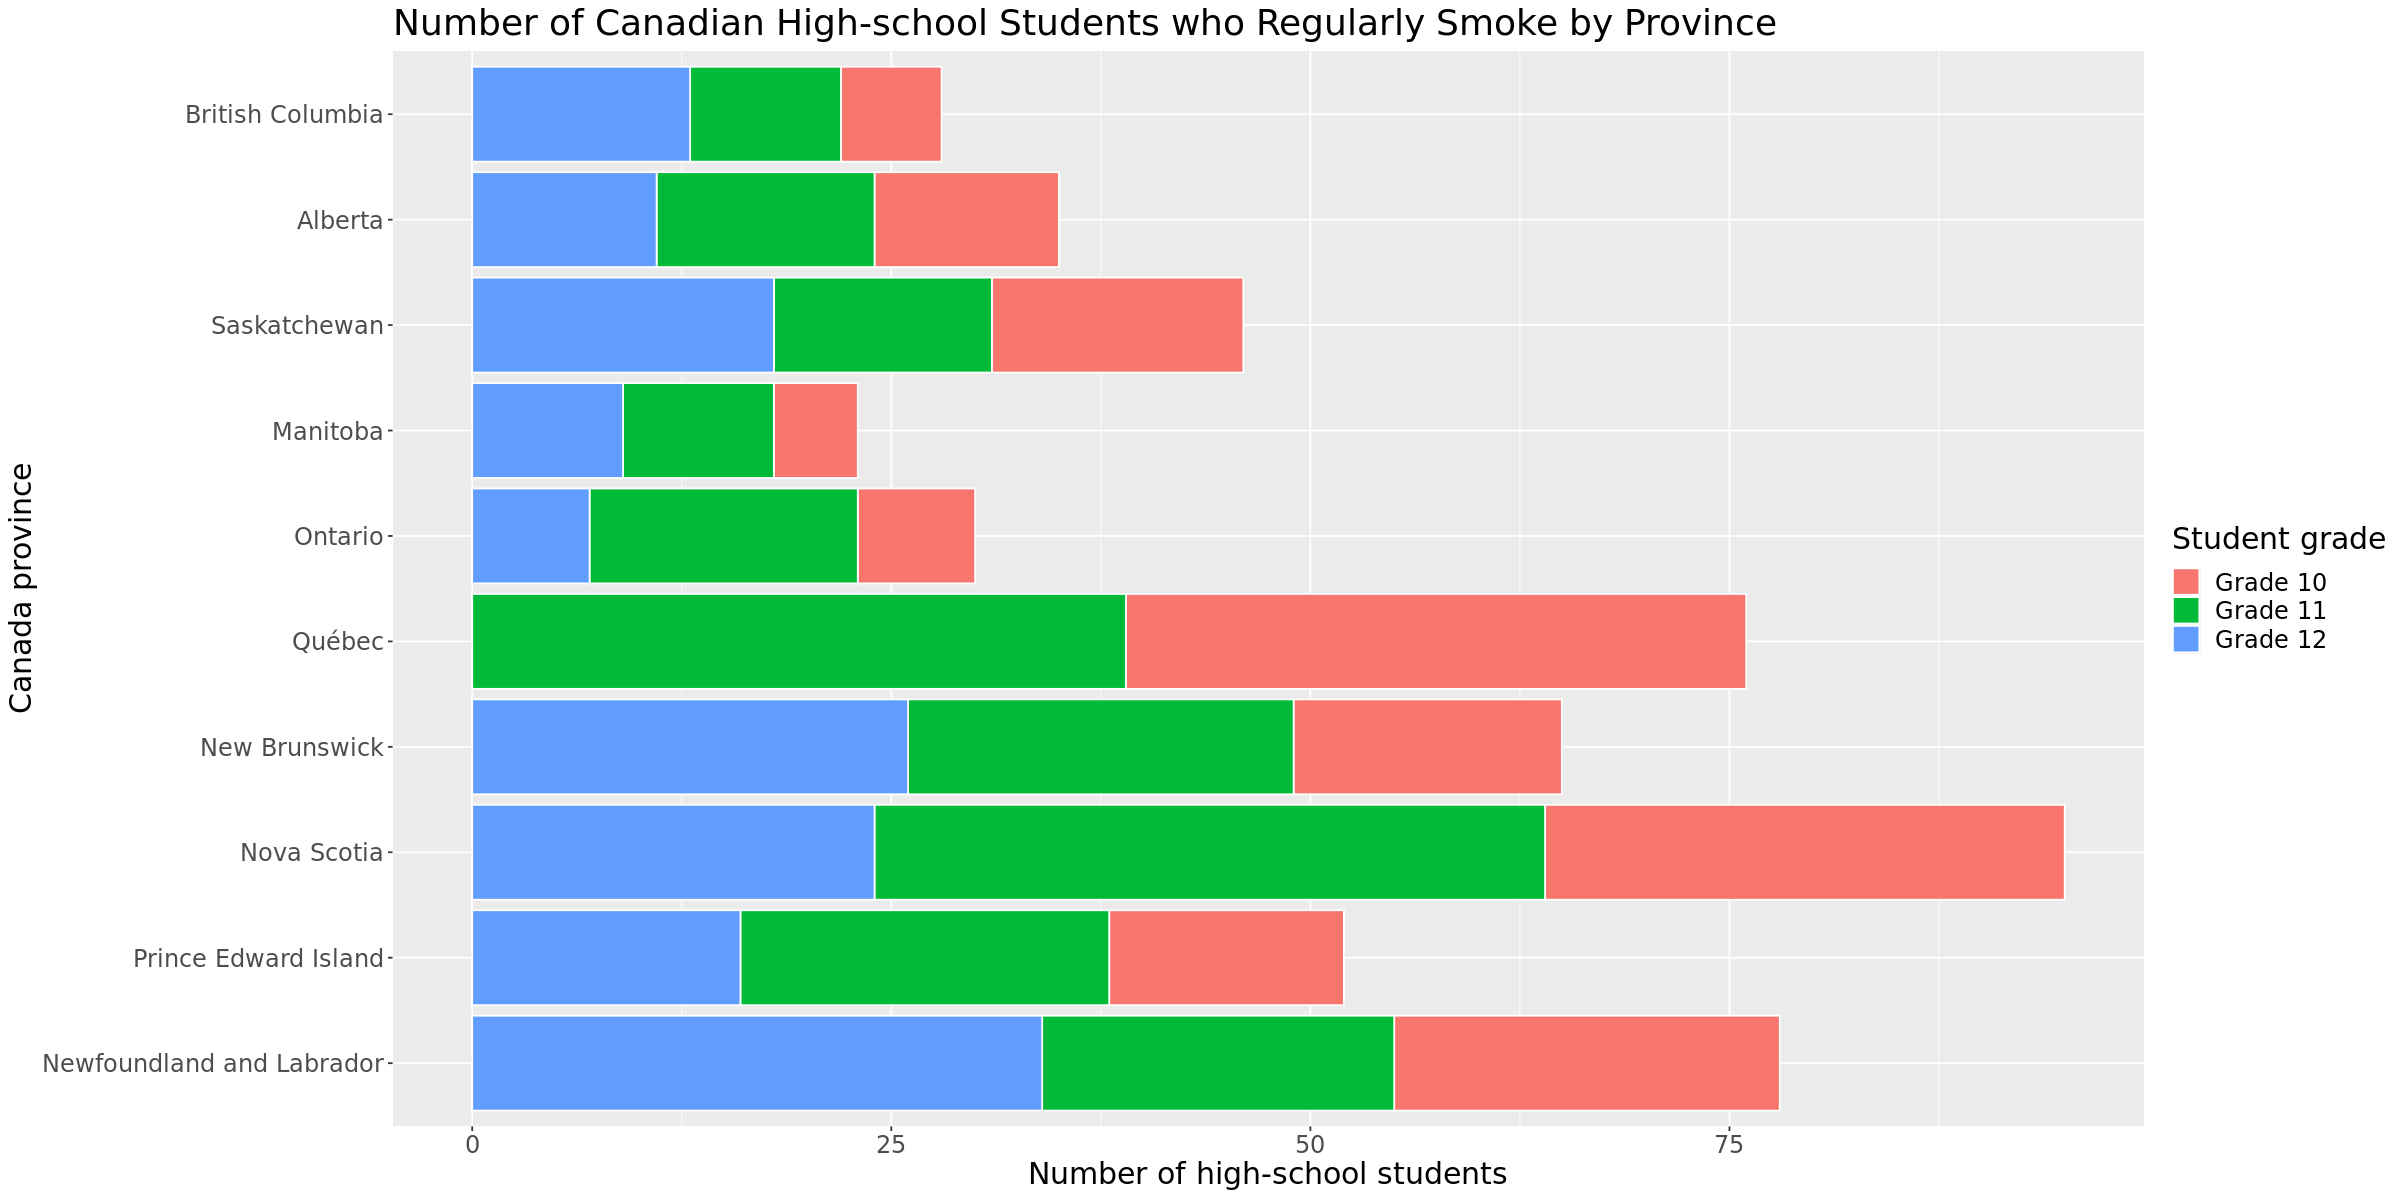

In [50]:
options(repr.plot.width = 20, repr.plot.height = 10)

all_provinces %>%
  ggplot(aes(x = PROVID, fill = GRADE)) +
  geom_bar(color = "white") +
  labs(title = "Number of Canadian High-school Students who Regularly Smoke by Province",
       x = "Canada province",
       y = "Number of high-school students",
       fill = "Student grade") +
  coord_flip() +
  theme(text = element_text(size = 18))

The bar chart shows that the BC province has a small number of regular high-school smokers comparing to other regions, and it also tells us that those BC students is almost evenly split between the grades.

Next, we can find our point estimate. For doing this, we add a new categorical variable to our data set that will represent whether a high-school student is a regular smoker. This new variable called `regular_smoker` is derived by again filtering through the variables discussed in the previous section. The resulting data frame is saved to `sample`.

In [56]:
sample <- data %>%
  filter(GRADE %in% 10:12,
         PROVID == 59) %>%
  mutate(regular_smoker = if_else(
    ((DVRES == 1 | DVRES == 3) &
      (SS_010 == 1) &
      (TS_011 %in% 1:2) &
      (TV_010 %in% 1:2) &
      (SS_030 == 1) &
      (SS_040 == 1) &
      (SS_060 %in% 7:8) &
      (WP_030 == 3 | WP_030 == 6)),
    "yes", "no"
  )) %>%
  select(regular_smoker)

sample %>% 
  head()

regular_smoker
<chr>
no
no
no
no
no
no


This data frame contains only a single column indicating a BC high-school student's smoking status.

In [57]:
sample %>%
  distinct()

regular_smoker
<chr>
no
yes


Using this data frame, we now find the sample proportion of BC high-school regular smokers, and this value is our point estimate as well.

In [61]:
point_estimate <- sample %>%
  summarise(prop = mean(regular_smoker == "yes"))

point_estimate

prop
<dbl>
0.009076175


### Methods
...


In [1]:
x <- 10

### References
...